# Final Project. Communities and Crime

The objective of this project is to predict the _ViolentCrimesPerPop_ quantity which ilustrates the number of violent crimes per n 100k population.

## Import all necessary packages

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Exploring and Cleaning Data

### Extract columns names from _communities.names_

In [52]:
with open("communities.names") as NamesFile:
    Lines = NamesFile.readlines()[75:203]
ColumnsNames = [Line.split()[1] for Line in Lines]

### Read data from _communities.data_

In [53]:
Data = pd.read_csv("communities.data", index_col=False, names=ColumnsNames)
# Check if DataFrame looks ok...
Data.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


For easier data manipulation, we will make a copy of the whole DataFrame without the _communityname_ column.

In [54]:
NewData = Data.drop(["communityname"], axis=1)
NewData

,state,county,community,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,1,0.19,0.33,0.02,0.90,0.12,0.17,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,1,0.00,0.16,0.12,0.74,0.45,0.07,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,1,0.00,0.42,0.49,0.56,0.17,0.04,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,1,0.04,0.77,1.00,0.08,0.12,0.10,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,1,0.01,0.55,0.02,0.95,0.09,0.05,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,10,0.01,0.40,0.10,0.87,0.12,0.16,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,10,0.05,0.96,0.46,0.28,0.83,0.32,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,10,0.16,0.37,0.25,0.69,0.04,0.25,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,10,0.08,0.51,0.06,0.87,0.22,0.10,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [55]:
# General info about the data
NewData.info()
# Getting number of communities
n_communities = len(NewData)
print(f"\nTotal of communities: {n_communities}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 127 entries, state to ViolentCrimesPerPop
dtypes: float64(100), int64(2), object(25)
memory usage: 1.9+ MB

Total of communities: 1994


### Dropping columns with deficient total data
Some columns might have half or more of the total data as non-defined, all these written as a "?", so we will drop the columns that might not help us for the analysis.

In [56]:
with open("DeficientColumnsData.csv", "w") as DefData:
    HalfNumCommunities = n_communities//2
    for ColumnName in NewData.columns:
        # Get number of "?" in given column and check if it is more or equal than the
        # total of communties
        Total_UnknownDataColumn = (NewData[ColumnName] == "?").sum()
        if Total_UnknownDataColumn >= HalfNumCommunities:

            DefData.write(f"{ColumnName},{Total_UnknownDataColumn}\n")
            NewData.drop(labels=[ColumnName], axis=1, inplace=True)

print(NewData.info())
NewData

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 103 entries, state to ViolentCrimesPerPop
dtypes: float64(100), int64(2), object(1)
memory usage: 1.6+ MB
None


,state,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,8,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,53,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,24,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,34,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,42,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,10,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1990,6,10,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1991,9,10,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,25,10,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


### Exploring isolated non-defined data
Now we will check if there is still columns with strings or non-numerical data in them.

In [57]:
NewData.dtypes[NewData.dtypes != "int64"][NewData.dtypes != "float64"]

OtherPerCap    object
dtype: object

We can see that _OtherPerCap_ column has object dtype so let's observe the head column.

In [58]:
NewData.OtherPerCap.head()

0    0.36
1    0.22
2    0.28
3    0.36
4    0.51
Name: OtherPerCap, dtype: object

It seems we have numerical data so let's search for any non-numerical data in it.

In [59]:
def CheckFloat(x):
    try:
        y = float(x)
        return True
    except ValueError:
        return False
    

Rows_NonNum_OtherPerCap = list( Data.OtherPerCap.index[NewData.OtherPerCap.apply(CheckFloat) == False])
Data.loc[Rows_NonNum_OtherPerCap, "OtherPerCap"]

130    ?
Name: OtherPerCap, dtype: object

In [60]:
# Replacing OtherPerPop in index 130 with the mean of the available data
def GetMean_PrevOtherPerPop(Data):
    Sum = 0.0
    Values = Data.OtherPerCap.values
    for Val in Values:
        try:
            Sum += float(Val)
        except ValueError:
            pass
    return Sum/len(Values)

NewData.loc[Rows_NonNum_OtherPerCap, "OtherPerCap"] = GetMean_PrevOtherPerPop(NewData)
NewData = NewData.astype({"OtherPerCap":"float64"})

### Getting final DataFrame
For the final DataFrame, we will also drop the _state_ and _fold_ columns since they are categorical data

In [61]:
NewData.drop(["state", "fold"], axis=1, inplace=True)
NewData

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


In [62]:
NewData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 101 entries, population to ViolentCrimesPerPop
dtypes: float64(101)
memory usage: 1.5 MB


## Exploratory Data Analysis

<AxesSubplot: >

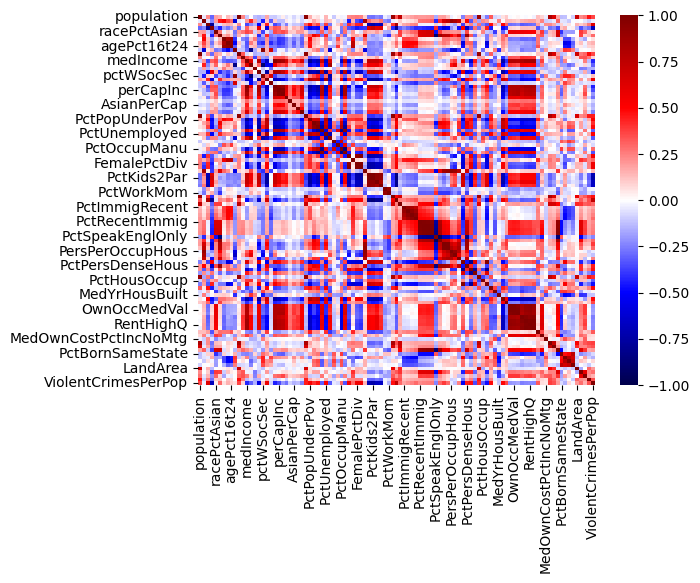

In [63]:
CorrMap = NewData.corr()

sns.heatmap(CorrMap, vmin=-1, vmax=1, cmap="seismic", annot=False)